<a href="https://colab.research.google.com/github/paultgriffiths/colab_notes/blob/main/Plot_CMIP6_3hr_pressure_data_make_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Boilerplate to set up env

In [1]:
import xarray as xr
!pip install zarr gcsfs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs


import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
#from IPython.display import HTML, Image # For GIF

xr.set_options(display_style='html')

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

import datetime

!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install pyproj==1.9.6

from mpl_toolkits.basemap import Basemap


Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
  Using cached https://github.com/matplotlib/basemap/archive/master.zip
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759575 sha256=e75aa591d0c5a1327d05c478b7c6681e159324a5c392cfb679901013f0a3e732
  Stored in directory: /tmp/pip-ephem-wheel-cache-402fv05l/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
Successfully built basemap


### Function to query ESGF for avaialable data

In [3]:
# from __future__ import print_function
# import requests
# import xml.etree.ElementTree as ET
# import numpy

# # Author: Unknown
# # I got the original version from a word document published by ESGF
# # https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# # API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

# def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
#                 files_type="OPENDAP", local_node=True, project="CMIP6",
#                 verbose=False, format="application%2Fsolr%2Bjson",
#                 use_csrf=False, **search):
#     client = requests.session()
#     payload = search
#     payload["project"] = project
#     payload["type"]= "File"
#     if local_node:
#         payload["distrib"] = "false"
#     if use_csrf:
#         client.get(server)
#         if 'csrftoken' in client.cookies:
#             # Django 1.6 and up
#             csrftoken = client.cookies['csrftoken']
#         else:
#             # older versions
#             csrftoken = client.cookies['csrf']
#         payload["csrfmiddlewaretoken"] = csrftoken

#     payload["format"] = format

#     offset = 0
#     numFound = 10000
#     all_files = []
#     files_type = files_type.upper()
#     while offset < numFound:
#         payload["offset"] = offset
#         url_keys = [] 
#         for k in payload:
#             url_keys += ["{}={}".format(k, payload[k])]

#         url = "{}/?{}".format(server, "&".join(url_keys))
#         print(url)
#         r = client.get(url)
#         r.raise_for_status()
#         resp = r.json()["response"]
#         numFound = int(resp["numFound"])
#         resp = resp["docs"]
#         offset += len(resp)
#         for d in resp:
#             if verbose:
#                 for k in d:
#                     print("{}: {}".format(k,d[k]))
#             url = d["url"]
#             for f in d["url"]:
#                 sp = f.split("|")
#                 if sp[-1] == files_type:
#                     all_files.append(sp[0].split(".html")[0])
#     return sorted(all_files)
#     result = esgf_search(activity_id='ScenarioMIP', table_id='day', variable_id='psl', experiment_id='ssp370',
#                   institution_id="NCAR", source_id="CESM2", member_id="r10i1p1f1",version= '20200528' )
# !pip install netCDF4
# ds = xr.open_mfdataset(result[:], combine='by_coords')

### Better yet use the connected CMIP6 storage on Google Drive

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# df_psl_day = df.query("institution_id == 'NCAR' & source_id=='CESM2' & member_id=='r1i1p1f1' & activity_id=='CMIP' & table_id == 'daily' & variable_id == 'psl' & experiment_id == 'historical'")
# df_psl_day = df.query("institution_id == 'NCAR' & source_id=='CESM2' & member_id=='r1i1p1f1' & activity_id=='CMIP' & table_id == 'day' & variable_id == 'psl' & experiment_id == 'historical'")
df_psl_day = df.query(" table_id == 'E3hr' & variable_id == 'psl' & version=='20170906'")

In [5]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_psl_day.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)

### make animation and plot

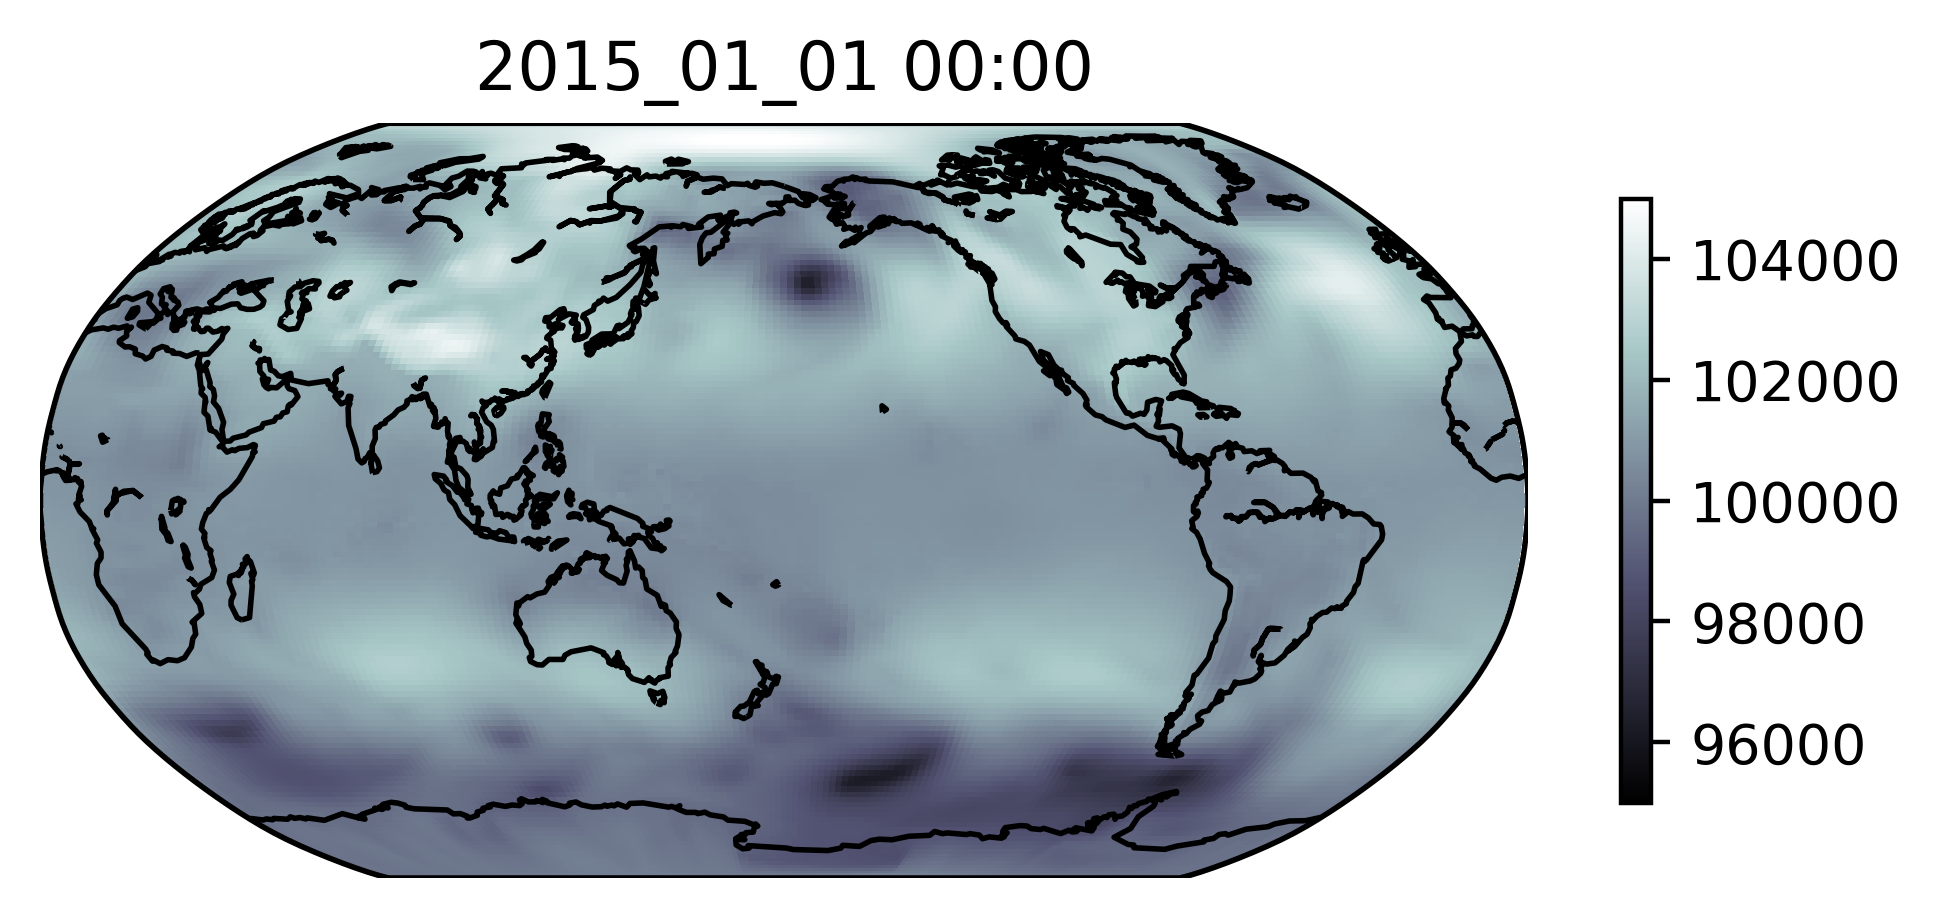

In [6]:
# can now plot
fig=plt.figure(dpi=200.)
ax=plt.subplot(1,1,1)
map = Basemap(projection='robin', lon_0=180)#,llcrnrlat=-89.9,urcrnrlat=89.9, llcrnrlon=-180,urcrnrlon=180,lat_ts=10,resolution='c')
map.drawcoastlines()
#We need to prime the pump, so to speak and create a quadmesh for plt to work with
a = ds.psl[0,:,:].squeeze().data
lon=np.array(ds.psl.lon.values)
lat=np.array(ds.psl.lat.values)
X,Y = np.meshgrid(lon, lat) 
cs1 = map.pcolormesh(X,Y, data=a, latlon = True, vmin=95000., vmax=105000.,cmap ='bone')#, shading='gouraud')# transform=ccrs.PlateCarree())
plt.colorbar(shrink=0.5)


def animate(i):
    date = datetime.datetime(2015, 1, 1)
    
    #This is where new data is inserted into the plot.
    a = ds.psl[i,:,:].squeeze().data
    cs1.set_array(a[:-1,:-1].ravel())
    date = date + datetime.timedelta(days=i/4)
    
    datelabel = format(datetime.datetime.strftime(date, '%Y_%m_%d %H:%M'))
    ax.set_title(datelabel)
    return cs1

anim = animation.FuncAnimation(fig, animate, frames=240, interval=1000, blit=False, repeat=True)

In [ ]:
from matplotlib import rc
rc('animation', html='jshtml')
#rc('animation', html='html5')

## Uncomment to save the animation
writer = animation.FFMpegWriter(fps=8, metadata=dict(artist='Paul Griffiths'), bitrate=1800)

anim.save('sea_level_pressure_HadGEM3-GC3.1_2015_Jan.mp4', writer=writer)